# 1. Installing Libraries

In [186]:
# importing standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint,uniform

# importing preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight


from sklearn.model_selection import train_test_split,StratifiedKFold

from sklearn.dummy import DummyClassifier

#importing modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# importing evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, make_scorer

# importing hyperparameter tuning libraries
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings("ignore")

# 2. Importing Dataset

In [187]:
# reading the data
df=pd.read_csv('Data/classification_density.csv')

In [188]:
# checking the colmn names
df.columns

Index(['sample', 'parameter', 'value'], dtype='object')

In [189]:
# checking the first 10 rows
df.head(10)

,sample,parameter,value
0,02-03324,particle density,1.0908
1,02-03324,bulk density,28.0000
2,02-03325,bulk density,28.6000
3,02-03325,particle density,1.0883
4,02-05854,particle density,1.1031
5,02-05854,bulk density,41.1000
6,02-06141,particle density,1.1063
7,02-06141,bulk density,40.3000
8,02-06142,bulk density,40.5000
9,02-06142,particle density,1.1057


In [190]:
# descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
value,3547.0,17.154231,16.5365,0.0,1.09505,1.1186,34.0,52.0


In [191]:
# checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample     3547 non-null   object 
 1   parameter  3547 non-null   object 
 2   value      3547 non-null   float64
dtypes: float64(1), object(2)
memory usage: 83.3+ KB


In [192]:
# checking the dimensions of the data
df.shape

(3547, 3)

# 3. Importing Labels

In [193]:
# reading the label data
df_labels=pd.read_csv('classification_labels.csv')

In [194]:
# checking the first 5 rows
df_labels.head()

,sample,finalform
0,02-03324,Powder
1,02-05854,Pellets
2,02-06141,Pellets
3,02-06142,Pellets
4,02-06143,Pellets


In [195]:
# checking the dimensions of the label data to see how it compares with the main data
df_labels.shape

(1609, 2)

# 4. Data Preprocessing

In [196]:
# checking duplicates
df.duplicated().sum()

2

In [197]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [198]:
# checking null values
df.isnull().sum()

sample       0
parameter    0
value        0
dtype: int64

In [199]:
df.head(10)

,sample,parameter,value
0,02-03324,particle density,1.0908
1,02-03324,bulk density,28.0000
2,02-03325,bulk density,28.6000
3,02-03325,particle density,1.0883
4,02-05854,particle density,1.1031
5,02-05854,bulk density,41.1000
6,02-06141,particle density,1.1063
7,02-06141,bulk density,40.3000
8,02-06142,bulk density,40.5000
9,02-06142,particle density,1.1057


In [200]:
# creating new columns for particle and bulk densities
df['particle_density']=df['value'][df['parameter']=='particle density']
df['bulk_density']=df['value'][df['parameter']=='bulk density']


In [201]:
# confirming the new columns
df.head()

,sample,parameter,value,particle_density,bulk_density
0,02-03324,particle density,1.0908,1.0908,NaN
1,02-03324,bulk density,28.0000,NaN,28.0
2,02-03325,bulk density,28.6000,NaN,28.6
3,02-03325,particle density,1.0883,1.0883,NaN
4,02-05854,particle density,1.1031,1.1031,NaN


In [202]:
# Separating the df for each measurement to facilitate proper handling of null values
df_particle_density=df[['sample','particle_density']]
df_bulk_density=df[['sample','bulk_density']]

In [203]:
# Null values in the two dataframes
print(df_particle_density.isna().sum())
print(df_bulk_density.isna().sum())

sample                 0
particle_density    1776
dtype: int64
sample             0
bulk_density    1769
dtype: int64


In [204]:
# dropping null values in the two dataframes separately
df_particle_density.dropna(inplace=True)
df_bulk_density.dropna(inplace=True)

In [205]:
# merging the two dataframes using full outer join to ensure that the join in done correctly. If done incorrectly, there would be null values in the merged dataframe
df=pd.merge(df_particle_density,df_bulk_density,on='sample',how='outer')

In [206]:
# checking if there are null values in the merged dataframe which would indicate misalignment between the two dataframes
df.isna().sum()

sample              0
particle_density    0
bulk_density        0
dtype: int64

In [207]:
# checking the dimensions of the merged dataframe
df.shape

(1776, 3)

In [208]:
df.head(20)

,sample,particle_density,bulk_density
0,02-03324,1.0908,28.0
1,02-03325,1.0883,28.6
2,02-05854,1.1031,41.1
3,02-06141,1.1063,40.3
4,02-06142,1.1057,40.5
5,02-06143,1.1067,34.8
6,02-06144,1.1067,35.3
7,02-08391,1.0730,35.8
8,02-08392,1.0727,36.4
9,02-09587,1.0852,27.4


# 5. Merging the Labels Dataframe with the Main Dataframe

In [209]:
# merging the labels dataframe with the main dataframe
df=pd.merge(df,df_labels,on='sample',how='left')

In [210]:
df.head()   

,sample,particle_density,bulk_density,finalform
0,02-03324,1.0908,28.0,Powder
1,02-03325,1.0883,28.6,NaN
2,02-05854,1.1031,41.1,Pellets
3,02-06141,1.1063,40.3,Pellets
4,02-06142,1.1057,40.5,Pellets


In [211]:
# unlabeled samples
df.isna().sum()

sample                0
particle_density      0
bulk_density          0
finalform           160
dtype: int64

# 6. Separating the Unlabelled Samples

In [212]:
# creating a new dataframe for the labeled samples
oos_df=df[df['finalform'].isna()]

In [213]:
oos_df.shape

(160, 4)

In [214]:
# dropping null values from the main dataframe to exclude unlabeled samples
df.dropna(inplace=True)

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1616 entries, 0 to 1775
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sample            1616 non-null   object 
 1   particle_density  1616 non-null   float64
 2   bulk_density      1616 non-null   float64
 3   finalform         1616 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.1+ KB


In [216]:
# Descriptive statistics of the final dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
particle_density,1616.0,1.091346,0.030453,0.0,1.0821,1.0953,1.1018,1.1265
bulk_density,1616.0,33.103168,5.839326,0.0,29.0000,34.0000,37.1625,52.0000


# 7. EDA

## 7.1. Class Distribution

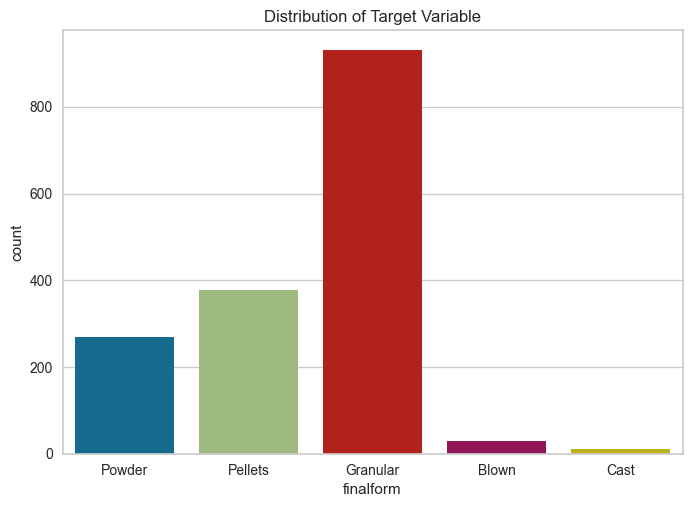

In [157]:
sns.countplot(x='finalform',data=df)
plt.title('Distribution of Target Variable');

## 7.2.  Univariate Analysis

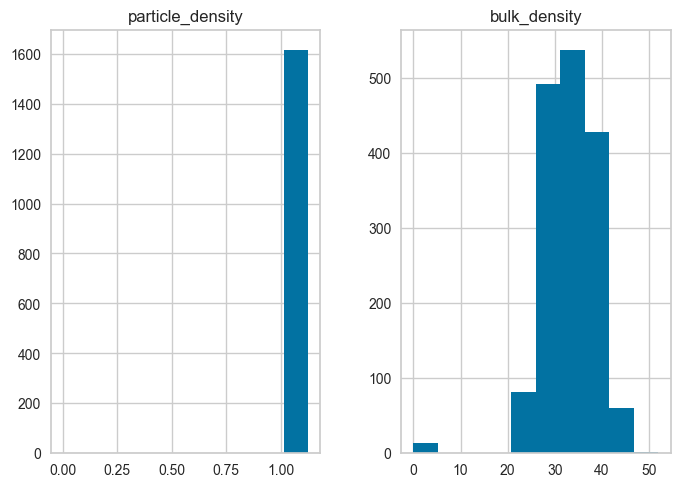

In [158]:
df.hist();

## 7.3. Bivariate Analysis

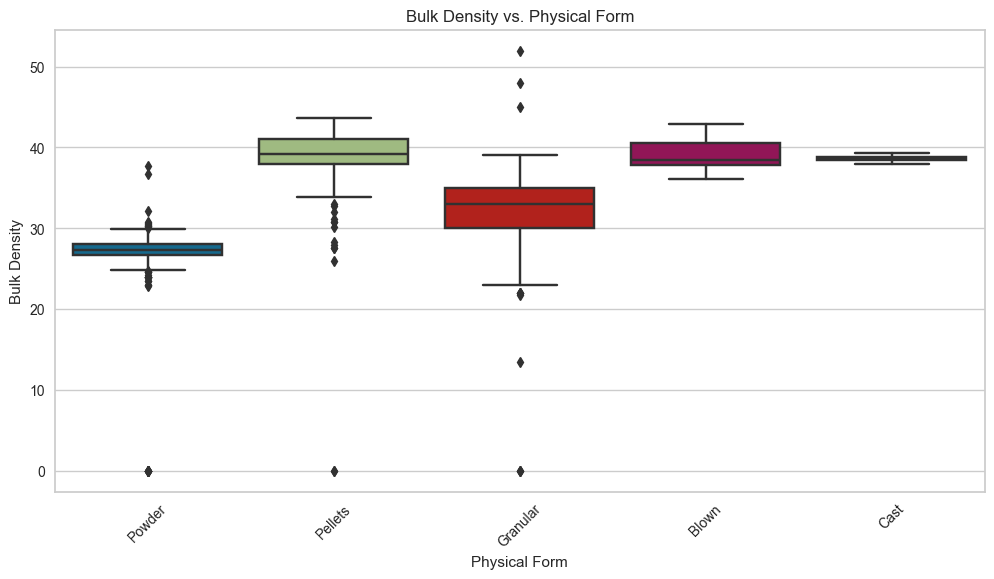

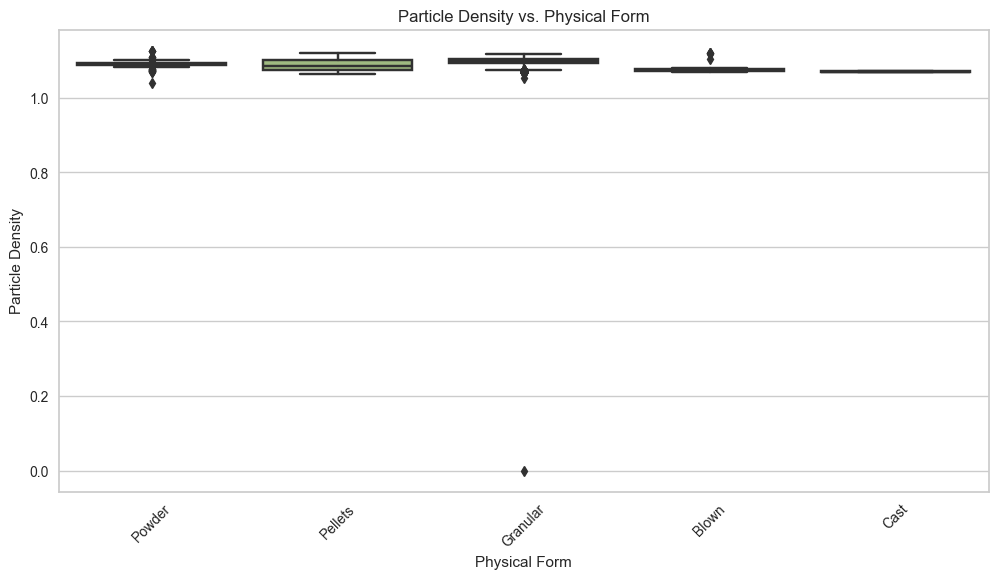

In [159]:
# Box plot for final form vs bulk density
plt.figure(figsize=(12, 6))
sns.boxplot(x='finalform', y='bulk_density', data=df)
plt.title('Bulk Density vs. Physical Form')
plt.xlabel('Physical Form')
plt.ylabel('Bulk Density')
plt.xticks(rotation=45)
plt.show()

# Box plot for final form vs particle density
plt.figure(figsize=(12, 6))
sns.boxplot(x='finalform', y='particle_density', data=df)
plt.title('Particle Density vs. Physical Form')
plt.xlabel('Physical Form')
plt.ylabel('Particle Density')
plt.xticks(rotation=45)
plt.show()

### 7.3.1.  Correlation Between Particle Density and Bulk Density 

In [160]:
# correlation between particle density and bulk density
df[['particle_density','bulk_density']].corr()

,particle_density,bulk_density
particle_density,1.000000,0.063887
bulk_density,0.063887,1.000000


# 8. Defining the Features and the Target

In [161]:
X=df[['particle_density','bulk_density']]
y=df['finalform']


# 9. Stratified Sampling to Account for Class Imbalance
- Train, test, and validation sets

In [162]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.4,random_state=42,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=0.5,random_state=42,stratify=y_val)

In [163]:
# Encoding the target column. Although this step is not required for most algos, it is better to perform this to ensure compatibility with any algo
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_val=encoder.transform(y_val)

# 10. Function to Evaluate Model 

In [164]:
from matplotlib.colors import ListedColormap
def clf_score(clf, X_val, y_val):
    predictions_val = clf.predict(X_val)
    
    print(f"Classification Report: \n {classification_report(y_val, predictions_val, target_names=encoder.classes_)}")
    ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val,display_labels=encoder.classes_).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
    plt.show()
    print("End of validation Result\n")

# 11.  Modeling

## 11.1.  Baseline with Dummy Classifier

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.00      0.00      0.00         6
        Cast       0.00      0.00      0.00         2
    Granular       0.57      0.54      0.56       186
     Pellets       0.22      0.23      0.22        75
      Powder       0.18      0.20      0.19        54

    accuracy                           0.40       323
   macro avg       0.19      0.19      0.19       323
weighted avg       0.41      0.40      0.40       323



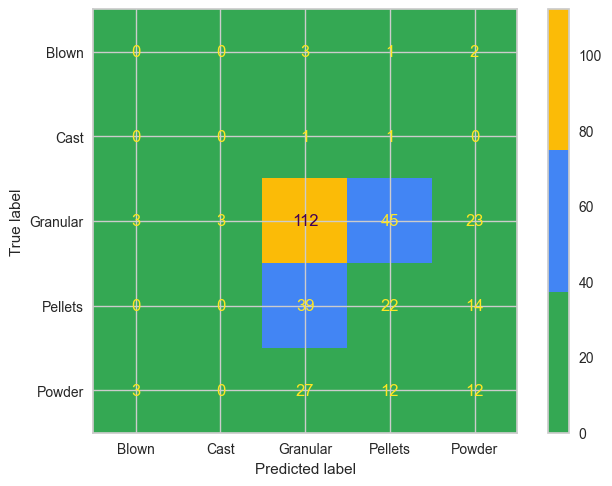

End of validation Result



In [165]:
baseline=DummyClassifier(strategy='stratified')
baseline.fit(X_train,y_train)
clf_score(baseline,X_val,y_val)

## 11.2. Logistic Regression

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.00      0.00      0.00         6
        Cast       0.00      0.00      0.00         2
    Granular       0.77      0.93      0.84       186
     Pellets       0.83      0.87      0.85        75
      Powder       0.60      0.22      0.32        54

    accuracy                           0.77       323
   macro avg       0.44      0.40      0.40       323
weighted avg       0.74      0.77      0.74       323



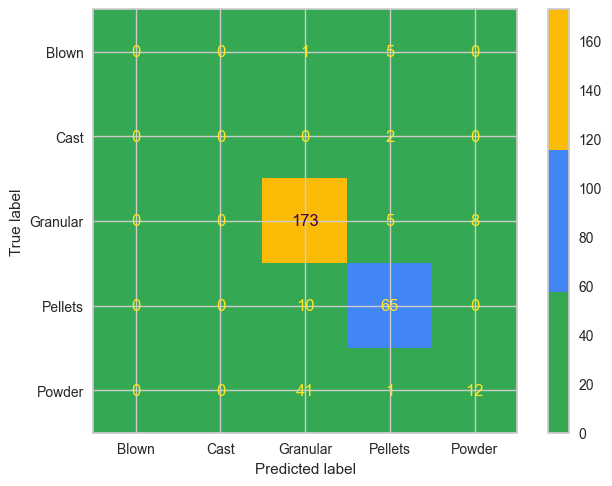

End of validation Result



In [166]:
logreg=LogisticRegression(random_state=42)
logreg.fit(X_train,y_train)
clf_score(logreg,X_val,y_val)

### 11.2.1. Scaling for Logistic Regression

In [167]:
# instantiate the standard scaler
scaler=StandardScaler()
# fit and transform the training data
X_train_scaled=scaler.fit_transform(X_train)
# transform the validation data without fitting to prevent data leakage
X_test_scaled=scaler.transform(X_val)

### 11.2.2. Logistic Regression with Scaled Features

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.00      0.00      0.00         6
        Cast       0.00      0.00      0.00         2
    Granular       0.81      0.98      0.88       186
     Pellets       0.88      0.92      0.90        75
      Powder       0.84      0.30      0.44        54

    accuracy                           0.83       323
   macro avg       0.51      0.44      0.44       323
weighted avg       0.81      0.83      0.79       323



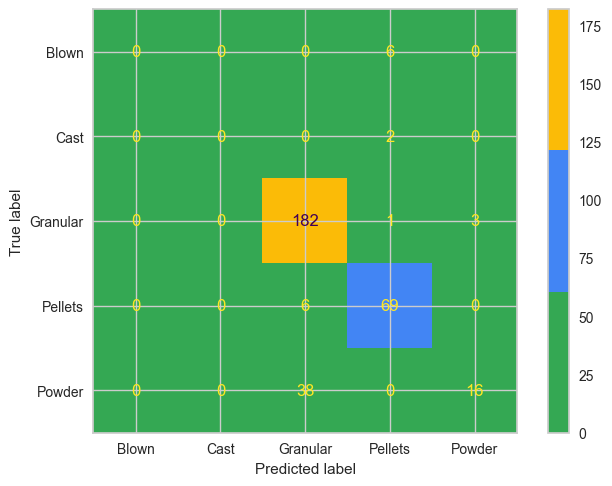

End of validation Result



In [168]:
logreg.fit(X_train_scaled,y_train)
clf_score(logreg,X_test_scaled,y_val)

### 11.2.3. Logisitc Regression with Class weight set to Balanced to Handle Class Imbalance

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.00      0.00      0.00         6
        Cast       0.06      1.00      0.12         2
    Granular       0.97      0.73      0.83       186
     Pellets       0.50      0.24      0.32        75
      Powder       0.61      0.94      0.74        54

    accuracy                           0.64       323
   macro avg       0.43      0.58      0.40       323
weighted avg       0.78      0.64      0.68       323



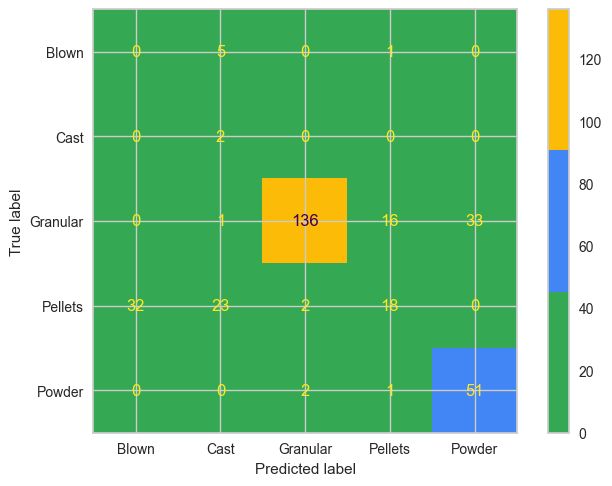

End of validation Result



In [169]:
logreg_weighted=LogisticRegression(random_state=42,class_weight='balanced')
logreg_weighted.fit(X_train_scaled,y_train)
clf_score(logreg_weighted,X_test_scaled,y_val)


## 11.3. Decision Tree 

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.14      0.17      0.15         6
        Cast       0.25      0.50      0.33         2
    Granular       0.91      0.94      0.92       186
     Pellets       0.88      0.85      0.86        75
      Powder       0.83      0.74      0.78        54

    accuracy                           0.87       323
   macro avg       0.60      0.64      0.61       323
weighted avg       0.87      0.87      0.87       323



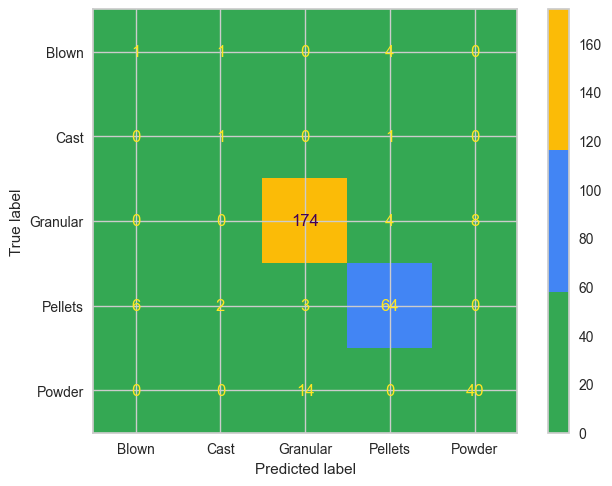

End of validation Result



In [170]:
dt_model=DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train,y_train)
clf_score(dt_model,X_val,y_val)

### 11.3.1. Decision Tree with Class Weight set to Balanced

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.20      0.17      0.18         6
        Cast       0.33      0.50      0.40         2
    Granular       0.90      0.96      0.93       186
     Pellets       0.89      0.84      0.86        75
      Powder       0.89      0.76      0.82        54

    accuracy                           0.88       323
   macro avg       0.64      0.65      0.64       323
weighted avg       0.88      0.88      0.88       323



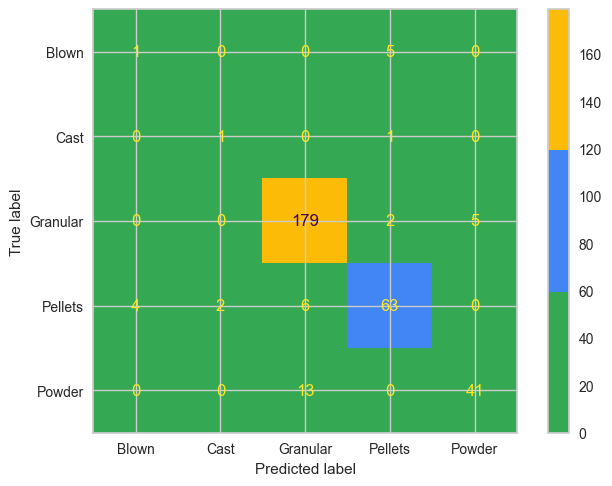

End of validation Result



In [171]:
dt_model_weighted=DecisionTreeClassifier(random_state=42,class_weight='balanced')
dt_model_weighted.fit(X_train,y_train)
clf_score(dt_model_weighted,X_val,y_val)

## 11.4. Random Forest

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.33      0.17      0.22         6
        Cast       0.50      0.50      0.50         2
    Granular       0.94      0.96      0.95       186
     Pellets       0.89      0.91      0.90        75
      Powder       0.90      0.85      0.88        54

    accuracy                           0.91       323
   macro avg       0.71      0.68      0.69       323
weighted avg       0.91      0.91      0.91       323



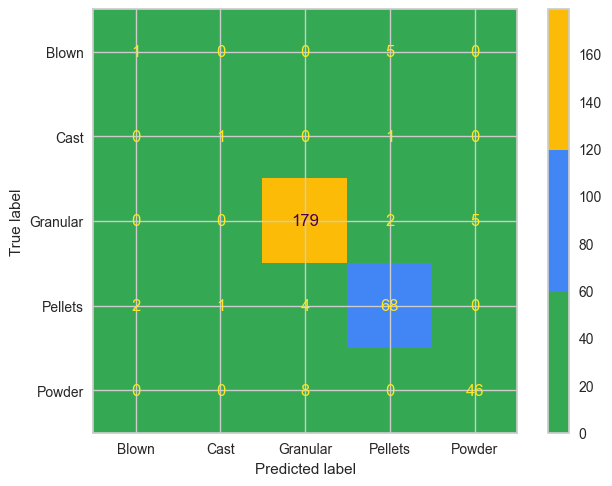

End of validation Result



In [172]:
rf_model=RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)
clf_score(rf_model,X_val,y_val)

### 11.4.1 Random Forest with Class Weight Set to Balanced

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.20      0.17      0.18         6
        Cast       1.00      0.50      0.67         2
    Granular       0.94      0.97      0.95       186
     Pellets       0.91      0.89      0.90        75
      Powder       0.90      0.85      0.88        54

    accuracy                           0.91       323
   macro avg       0.79      0.68      0.72       323
weighted avg       0.91      0.91      0.91       323



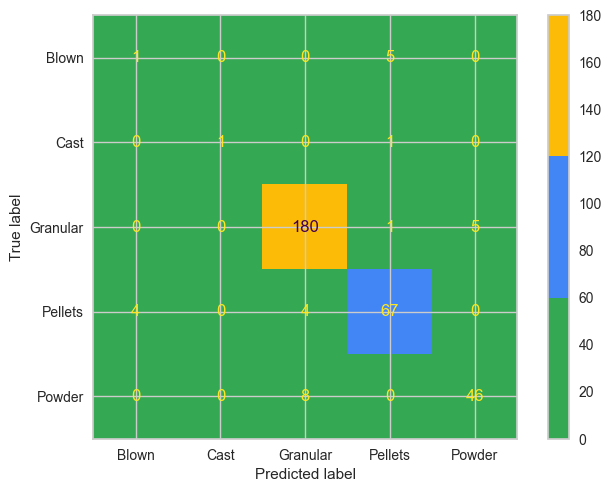

End of validation Result



In [173]:
rf_model_weighted=RandomForestClassifier(random_state=42,class_weight='balanced')
rf_model_weighted.fit(X_train,y_train)
clf_score(rf_model_weighted,X_val,y_val)

## 11.5. XGBoost

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.50      0.17      0.25         6
        Cast       0.25      0.50      0.33         2
    Granular       0.93      0.96      0.95       186
     Pellets       0.89      0.89      0.89        75
      Powder       0.90      0.83      0.87        54

    accuracy                           0.91       323
   macro avg       0.70      0.67      0.66       323
weighted avg       0.91      0.91      0.90       323



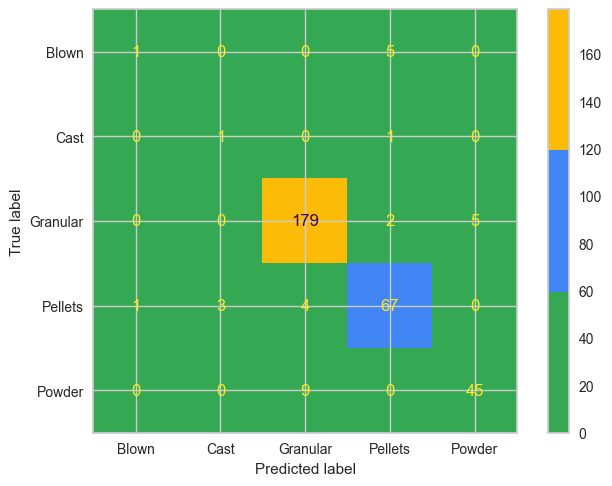

End of validation Result



In [174]:
xgb_model=xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train,y_train)
clf_score(xgb_model,X_val,y_val)

## 11.5.1. XGBoost With Sample Weight

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.50      0.33      0.40         6
        Cast       0.20      0.50      0.29         2
    Granular       0.94      0.96      0.95       186
     Pellets       0.89      0.87      0.88        75
      Powder       0.90      0.87      0.89        54

    accuracy                           0.91       323
   macro avg       0.69      0.71      0.68       323
weighted avg       0.91      0.91      0.91       323



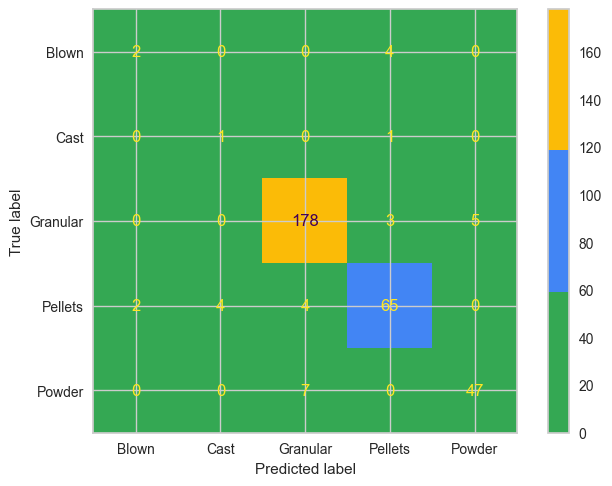

End of validation Result



In [175]:
sample_weights = compute_sample_weight('balanced', y_train)

# Create the XGBClassifier
xgb_model_weighted = xgb.XGBClassifier(random_state=42)
xgb_model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate the model
best_score = clf_score(xgb_model_weighted, X_val, y_val)

# 12. Hyperparameter Tuning

## 12.1. Hyperparameter Tuning for XGBoost

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=0.22059818254342153, max_depth=3, n_estimators=70; total time=   0.2s
[CV] END learning_rate=0.22059818254342153, max_depth=3, n_estimators=70; total time=   0.2s
[CV] END learning_rate=0.22059818254342153, max_depth=3, n_estimators=70; total time=   0.2s
[CV] END learning_rate=0.11336203565420874, max_depth=3, n_estimators=320; total time=   0.7s
[CV] END learning_rate=0.11336203565420874, max_depth=3, n_estimators=320; total time=   0.7s
[CV] END learning_rate=0.11336203565420874, max_depth=3, n_estimators=320; total time=   0.7s
[CV] END learning_rate=0.04780559213273095, max_depth=5, n_estimators=264; total time=   0.8s
[CV] END learning_rate=0.04780559213273095, max_depth=5, n_estimators=264; total time=   0.8s
[CV] END learning_rate=0.04780559213273095, max_depth=5, n_estimators=264; total time=   0.8s
[CV] END learning_rate=0.18133450352296263, max_depth=6, n_estimators=180; total time=   1.7s


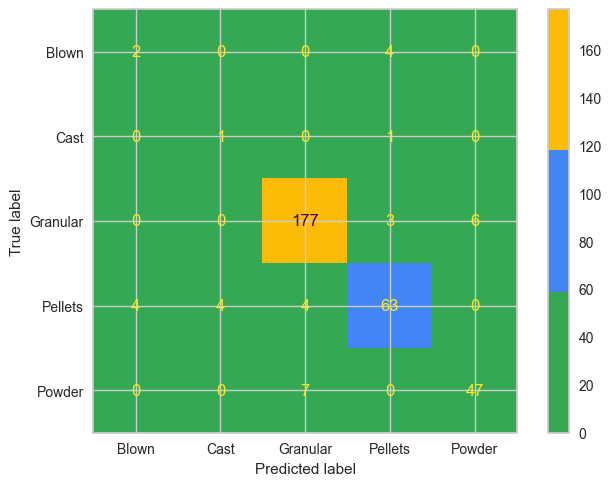

End of validation Result

Best parameters found: {'learning_rate': 0.04780559213273095, 'max_depth': 5, 'n_estimators': 264}


In [176]:
# Defining the parameter grid for learning_rate, max_depth, and n_estimators
param_dist = {
    'learning_rate': uniform(0.001, 0.3),  # Learning rate in the range [0.01, 0.31]
    'max_depth': randint(3, 7),  # Max depth from 3 to 7. 
    'n_estimators': randint(50, 1000)  # Number of trees from 50 to 1000
}

# Creating the RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(
    estimator=xgb_model_weighted,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=3,  # Cross-validation strategy (3-fold CV)
    verbose=2,  
    random_state=42,  
    n_jobs=-1  
)

# Fitting the RandomizedSearchCV object with sample weights
rf_random_search.fit(X_train, y_train, sample_weight=sample_weights)

# Getting the best model from the random search
best_xgb_model = rf_random_search.best_estimator_

# Evaluating the best model
best_score = clf_score(best_xgb_model, X_val, y_val)

# Printing the best parameters and score
print(f"Best parameters found: {rf_random_search.best_params_}")


## 12.2. Hyperparameter Tuning for Random Forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......................max_depth=3, n_estimators=320; total time=   1.5s
[CV] END ......................max_depth=5, n_estimators=485; total time=   2.3s
[CV] END ......................max_depth=5, n_estimators=485; total time=   2.3s
[CV] END ......................max_depth=5, n_estimators=485; total time=   2.3s
[CV] END ......................max_depth=5, n_estimators=121; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=320; total time=   1.4s
[CV] END ......................max_depth=5, n_estimators=121; total time=   0.6s
[CV] END .......................max_depth=3, n_estimators=70; total time=   0.3s
[CV] END .......................max_depth=3, n_estimators=70; total time=   0.3s
[CV] END ......................max_depth=5, n_estimators=121; total time=   0.7s
[CV] END ......................max_depth=3, n_estimators=320; total time=   1.5s
[CV] END .......................max_depth=3, n

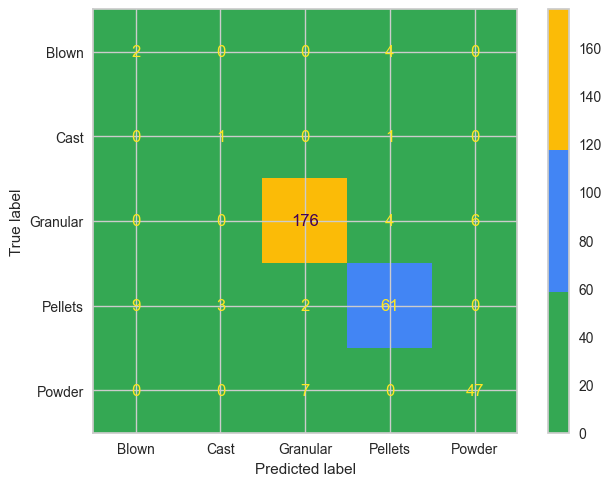

End of validation Result

Best parameters found: {'max_depth': 6, 'n_estimators': 145}


In [177]:
param_dist = {
    'n_estimators': randint(50, 1000),  # A wide range for number of trees
    'max_depth': randint(3, 7)  # A narrow range for max depth to avoid overfitting
}

# Creating the RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(
    estimator=rf_model_weighted,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=3,  # Cross-validation strategy (3-fold CV)
    verbose=2,  
    random_state=42,  
    n_jobs=-1  
)

# Fitting the RandomizedSearchCV object
rf_random_search.fit(X_train, y_train)

# Getting the best model from the random search
best_rf_model = rf_random_search.best_estimator_

# Evaluating the best model
best_score = clf_score(best_rf_model, X_val, y_val)

# Printing the best parameters and score
print(f"Best parameters found: {rf_random_search.best_params_}")


## Best Model: Tuned XGBoost Model
- The tuned XGBoost model will be used going forward.
- Although the tuned model may seem to have slightly lower performance metrics, these results are more reliable because they were obtained using k-fold cross-validation.


# 13. Feature Importance Plot

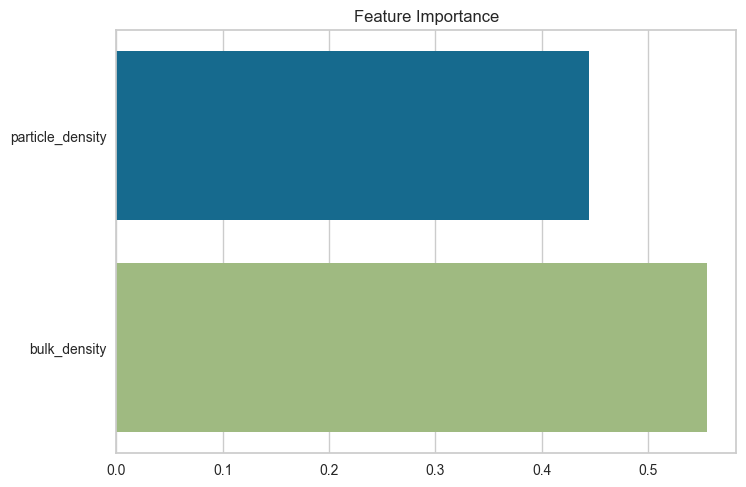

In [178]:
#plotting feature importance
feature_importances = best_xgb_model.feature_importances_
features = X_train.columns
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.show()

# 14. Analysing Prediction Errors

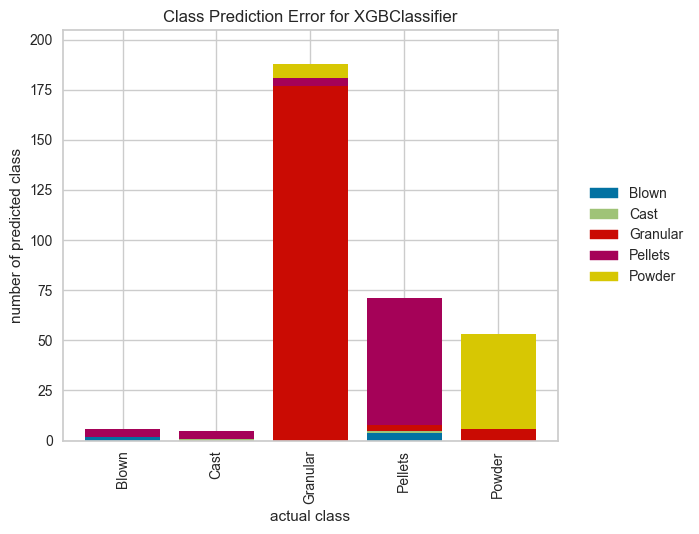

<Axes: title={'center': 'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [179]:
from yellowbrick.classifier import ClassPredictionError

# Defining the class labels based on the encoder
classes = encoder.classes_

# Initializing the ClassPredictionError visualizer
visualizer = ClassPredictionError(
    best_xgb_model, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluating the model on the test data
visualizer.score(X_val, y_val)

# Drawing the visualization
visualizer.show()

# 15. Validation Curve
- This shows how the model's performance varies with changes in a specific hyperparameter. It helps in understanding the impact of different hyperparameter values on the model's training and validation scores, allowing the identification of the optimal value that balances bias and variance, and ultimately improves the model's generalization capability.


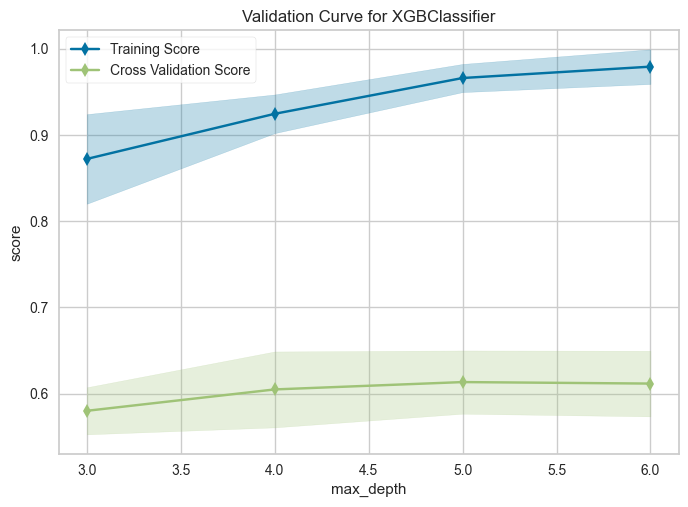

<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [180]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    best_xgb_model, 
    param_name="max_depth",
    param_range=np.arange(3, 7), 
    cv=5, 
    scoring="f1_macro",
    np_jobs=8
)

# Fitting and showing the visualizer
viz.fit(X_train, y_train)
viz.poof()

# 16. Learning Curve
- This shows how the model's performance changes as the number of training instances increases. It helps in diagnosing whether the model is suffering from high bias (underfitting) or high variance (overfitting). By examining the learning curve, it can be determined if adding more training data would improve the model's performance or if the model complexity needs adjustment.


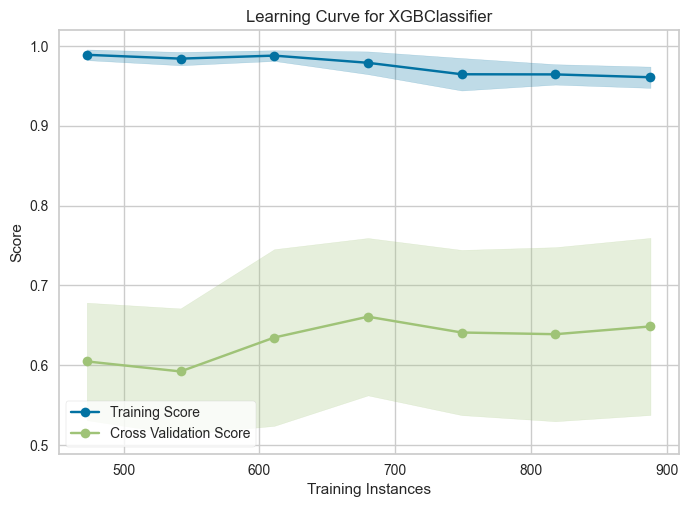

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [181]:
from yellowbrick.model_selection import LearningCurve


# Creating the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiating the classification model and visualizer

visualizer = LearningCurve(
    best_xgb_model, 
    cv=cv, 
    scoring='f1_macro', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train, y_train)        # Fitting the data to the visualizer
visualizer.poof()                       # Finalizing and rendering the figure

# 16. Evaluating Performance of the Best Model on the Test Set

Classification Report: 
               precision    recall  f1-score   support

       Blown       0.67      0.33      0.44         6
        Cast       0.00      0.00      0.00         2
    Granular       0.96      0.91      0.93       187
     Pellets       0.87      0.91      0.89        76
      Powder       0.79      0.91      0.84        53

    accuracy                           0.90       324
   macro avg       0.66      0.61      0.62       324
weighted avg       0.90      0.90      0.89       324



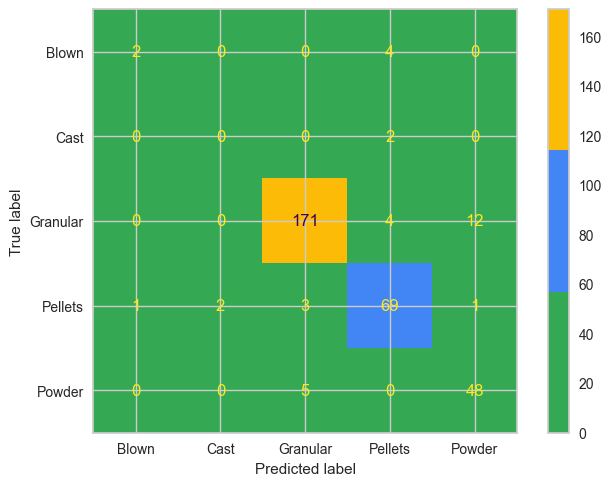

End of validation Result



In [182]:
# evaluating performace on test set
y_test=encoder.transform(y_test)
clf_score(best_xgb_model,X_test,y_test)

# 17. Making Predictions on the Unlabelled Samples

In [217]:
oos_x=oos_df[['particle_density','bulk_density']]  
predictions=best_xgb_model.predict(oos_x)

In [218]:
#saving the  predictions with the sample ids to a csv file
predictions=pd.DataFrame({'sample':oos_df['sample'],'finalform':encoder.inverse_transform(predictions)})
predictions.to_csv('predictions.csv',index=False)